# Tidying data

Data needs to be structured and organized to facilitate analysis. The idea of tidy data is related to the concept of data normalization (e.g. Codd's Normal Forms) in a relational database model. You may recall this in the earlier course on data modelling.

![data_normalization.png](images/data_normalization.png)

## What is tidy data?

In tidy data:
- Each variable has its own column
- Each observation has its own row
- Both variables (columns) and observations (rows) form a table

![untidy_tidy.png](images/untidy_tidy.png)

## Examples of untidy data

### Wide format

![untidy_wide.png](images/untidy_wide.png)

### Multiple values in a row

![untidy_multiple.png](images/untidy_multiple.png)
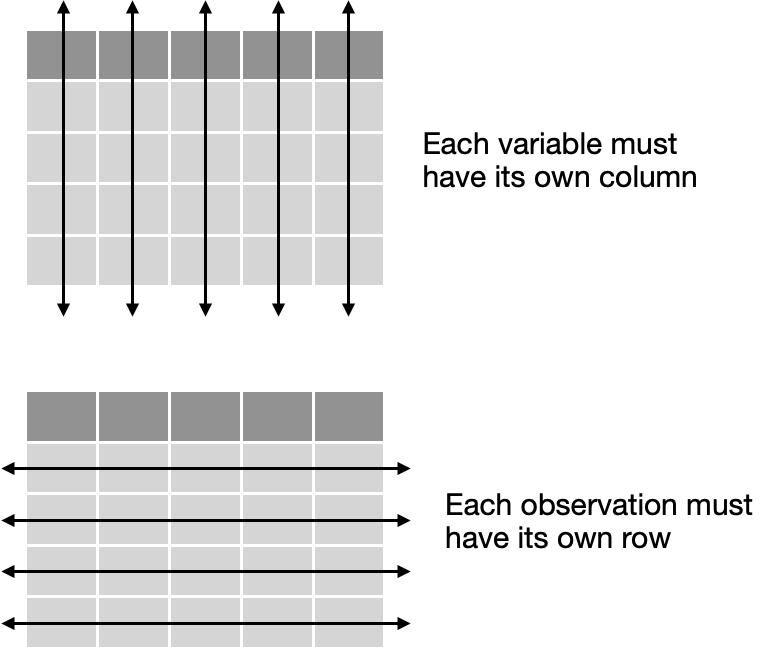
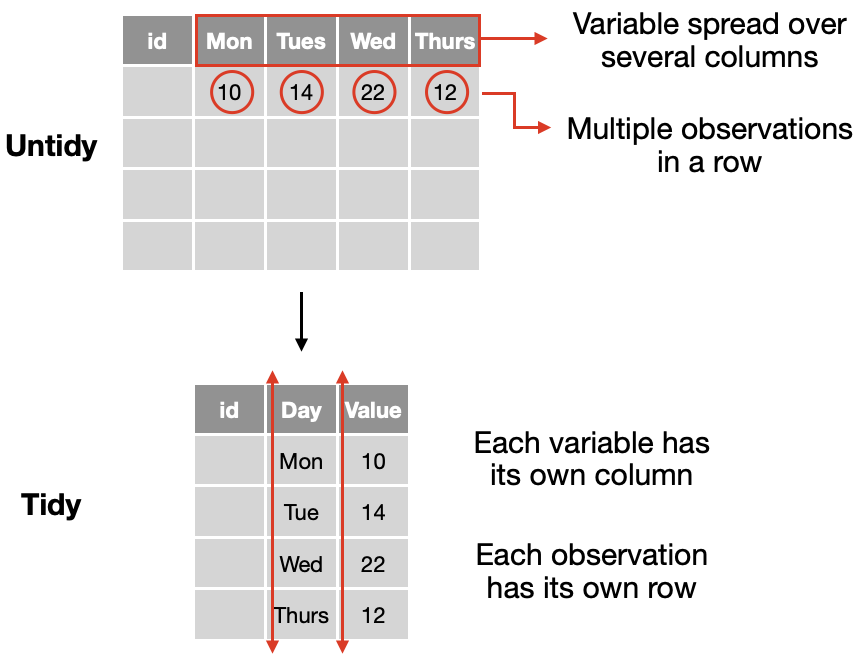

## Data preparation

We will use a COVID-19 dataset from an Imperial College London study (https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-symptom-progression-11-03-2020.pdf) to illustrate how we can tidy data for further analysis

In this dataset, data was collected from various sources from Hong Kong, Japan, Singapore and South Korea to examine the occurrence of symptoms and the progression of symptoms through time.

The variables include
- `new_id`: patient id
- `date_report`: date of report
- `country`: country of origin
- `age`: age of patient
- `date_onset`: date of onset
- `symptoms_at_onset`: symptoms at onset
- `date_first_consultation`: date of first consultation
- `date_symp_prog(1-4)`: date of symptoms at timepoints 1-4
- `symp_prog(1-4)`: symptoms at timepoints 1-4
- `any_symptom`: any reported symptom
- `date_hospitalised`: date hospitalized
- `date_death`: date of death
- `date_recovered`: date of recovery
- `source_name`: name of source of data
- `URL link (2/3)`: URL links for the data

In [ ]:
library(tidyverse)

data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/subset_international_cases_2020_03_11.csv")

head(data)

---
## Tidying data in wide format

In a wide format, related `categorical` data with its values are spread out into different `columns`. This makes analysis difficult in many cases

![transform_pivot.png](images/transform_pivot.png)

To transform data in a wide format to a tidy format, we use the `pivot_longer` function
```
pivot_longer(related_columns,
             names_to = column name to represent the related columns,
             values_to = column name for the values for related columns)
```
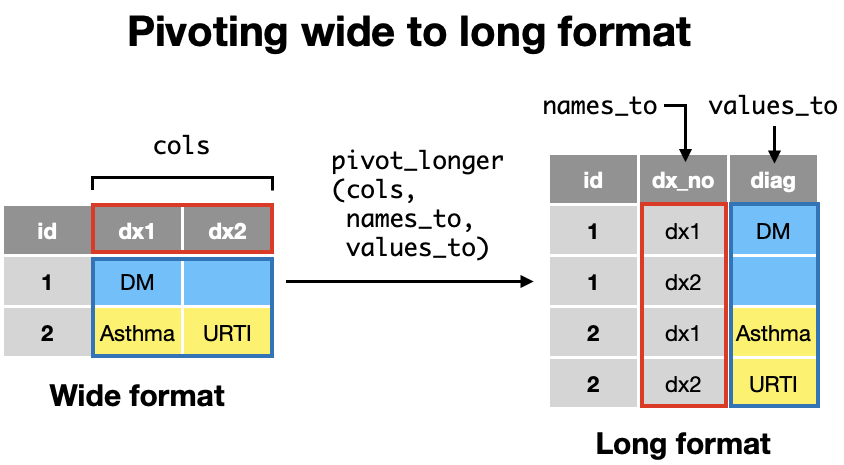

From the COVID-19 dataset, we will select several columns of interest **related to dates of events** to illustrate how we can transform data from the `wide` to `long` format

- `new_id`: patient id
- `date_report`: date infection reported
- `date_onset`: date of symptoms
- `date_first_consultation`: date of 1st visit
- `date_symp_prog(1-4)`: dates of symptom progression
- `date_hospitalized`: date of hospitalization
- `date_death`: date of death
- `date_recovery`: date of recovery

The columns with events related to dates have a prefix of `date_` and we can use the `starts_with` helper function to select them

In [ ]:
data_long <- data %>% 
             select(new_id, starts_with("date_"))

head(data_long)

We can see that the columns with the `date_` prefix represent **categories of events** for each of the dates for each patient in `new_id`
- We will pick the column names with the prefix `date_` using the `starts_with` helper function
- We will transform the **selected columns** as values into a new column `event` by specifying `names_to = "event"`
- We will transform the **date values** from the selected columns into a new `date` column by specifying `values_to = "date"`

In [ ]:
data_long <- data_long %>%
             pivot_longer(starts_with("date_"),  # helper function to select columns
                          names_to = "event",   # selected columns to new event column
                          values_to = "date") # date values to new date column

head(data_long)

When pivoting to the long format, the column names are transferred to the new column specified by ```names_to``` and the values are transferred to the new column specified by ```values_to```

Notice that the values all contain the prefix `date_` and we can remove them for clarity
- We can ```mutate``` the values in the new column to remove any repetitive prefixes/suffixes that were used using `str_replace` function
- The ```str_replace``` function matches the text specified by ```pattern``` and replaces it with a text specified by ```replacement```

```
str_replace(value, 
            pattern = "pattern to match", 
            replacement = "replacement text")
```

In [ ]:
# example of str_replace

str_replace("this is not good", 
            pattern = "not", 
            replacement ="very")

Here, we want to delete the prefix `date_`, we set the following arguments for `str_replace`
- `pattern = "date_"` to fix text that matches `date_`
- `replacement = ""` to replace it with empty text `""` i.e. deleting it

In [ ]:
# delete the date_ prefix using str_replace function with mutate verb

data_long <- data_long %>% 
             mutate(event = str_replace(event, 
                                        pattern = "date_", 
                                        replacement = ""))

head(data_long)

---
## Tidying data with multiple values in a row

Some datasets may contain multiple observations in a single row seperated by a delimiter (e.g. `,` `;`). This makes it hard to analyze the observations

![transform_separate.png](images/transform_separate.png)

To split the values into separate rows, we can use the `separate_rows` function

```
separate_rows(column containing multiple observations per row, 
              sep = "delimiter e.g. , or ;")
```

We will illustrate its use by looking at the `symptoms_at_onset` column from the COVID-19 dataset
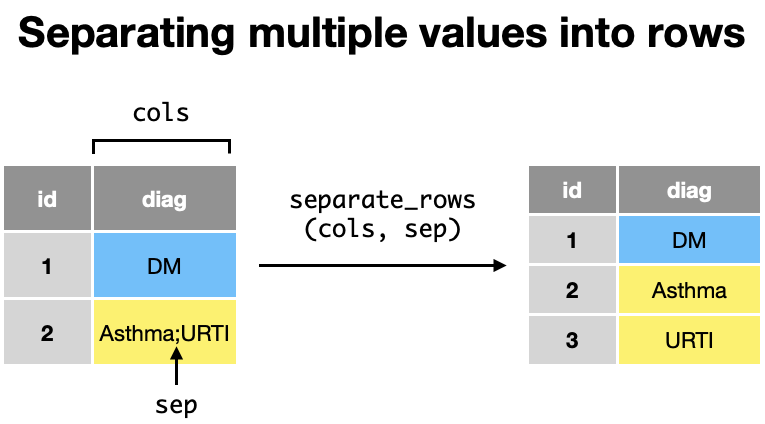

In [ ]:
data_untidy <- data %>%  
               select(new_id,
                      symptoms_at_onset)

head(data_untidy)

The multiple observations in `symptoms_at_onset` are separated by the delimiter `;` and we can specify this as `sep = ";"` in the `separate_rows` function

In [ ]:
data_untidy <- data_untidy %>% 
               separate_rows(symptoms_at_onset, 
                             sep=";")

head(data_untidy, n = 10)

---
## Example of tidying data

We will tidy the data by combining the concepts we learnt
- ```select```: choose only relevant variables for analysis
- ```pivot_longer```: change wide to long formats
- ```separate_rows```: separate values into different rows
- ```mutate```: change data types (e.g. factor for categorical)

We will import that COVID-19 dataset and remove the `URL` and `source_name` columns as we will not be using them

In [ ]:
data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/subset_international_cases_2020_03_11.csv")

data <- data %>% 
        select(-starts_with("URL"), -source_name)

head(data)

We start by transforming the **columns reporting symptoms** from the `wide` to `long` format using `pivot_longer`
- The column names are passed as a vector as there was no simple matching criteria that could be used with a helper function
- The column names are transformed to a new `symptom_order` column
- The values containing `symptoms` are transformed to a new `symptom` column

In [ ]:
data <- data %>% 
        pivot_longer(c("symptoms_at_onset",
                       "symp_prog1",
                       "symp_prog2",
                       "symp_prog3",
                       "symp_prog4",
                       "any_symptom"),
                      names_to="symptom_order",
                      values_to="symptom")

head(data)

Next, we will transform the **columns related to dates** from the `wide` to `long` format using `pivot_longer` as shown previously
- The column names are selected using the `starts_with` helper function
- The column names are transformed to a new `event` column
- The values containing `dates` are transformed to a new `date` column


In [ ]:
data <- data %>% 
        pivot_longer(starts_with("date_"), 
                     names_to = "event", 
                     values_to = "date")

head(data)

We next look at the `symptom` column to look at the unique/distinct values using the `distinct` function

In [ ]:
data %>% distinct(symptom)

As there are multiple observations of symptoms per row, we separate them using the `separate_rows` function and specifying the `;` delimiter

In [ ]:
data <- data %>% 
        separate_rows(symptom, sep=";")

head(data)

Finally, we need to convert the columns containing `categorical` data to `factors`

In [ ]:
data <- data %>% 
        mutate(new_id = as.factor(new_id),
               symptom = as.factor(symptom),
               event = as.factor(event))

head(data)

---
## Example of analysis

Now that we have tidy data, we can do a preliminary analysis by considering symptoms at the onset of COVID-19, then count the number of unique patients (```new_id```) to see what are the most frequent symptoms reported

We will first filter `symptom_order` for the category `symptoms_at_onset`

In [ ]:
data %>% 
filter(symptom_order == "symptoms_at_onset") %>% 
head()

Next, we want to count the number of symptoms and let us try to do this by using
- `group_by` to group by symptoms
- count the number of symptoms using `summarize` with `n()`
- `arrange` the results in descending order

In [ ]:
data %>% 
filter(symptom_order == "symptoms_at_onset") %>%  # filter only symptoms at onset
group_by(symptom) %>%                             # group by the different symptoms
summarize(n = n()) %>%                            # count number of rows
arrange(desc(n))

We note that the numbers do not look right and this is because we are counting the number of rows for each of the symptom groups, instead of the number of distinct patients

If we look at the filtered data, we can see that the symptom `fever` appears in multiple rows for the same patient `japan001`


In [ ]:
data %>% 
filter(symptom_order == "symptoms_at_onset") %>% 
head()

To count the number of distinct values for the patient in the `new_id` column, we can use the `n_distinct` function, which counts the number of distinct values in the specified column
- `n_distinct(column_name)`

In [ ]:
data %>% 
filter(symptom_order == "symptoms_at_onset") %>%  # filter only symptoms at onset
group_by(symptom) %>%                             # group by the different symptoms
summarize(n = n_distinct(new_id)) %>%             # count unique patients (new_id)
arrange(desc(n))

---
## Exercise - Tidying Data

We will use the COVID-19 dataset from Imperial College, UK

In [ ]:
library(tidyverse)

# import data
data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/subset_international_cases_2020_03_11.csv")

# exclude columns
data <- data %>% select(-starts_with("URL"), -source_name)

head(data)

In [ ]:
# recap of what was done

data2 <- data %>% 
         pivot_longer(c("symptoms_at_onset", # wide -> long for symptoms
                        "symp_prog1",
                        "symp_prog2",
                        "symp_prog3",
                        "symp_prog4",
                        "any_symptom"),
                       names_to="symptom_order",
                       values_to="symptom") %>%
         pivot_longer(starts_with("date"),  # wide -> long for date of symptom
                      names_to = "event", 
                      values_to="date") %>%
         separate_rows(symptom, sep=";") %>% # split multiple symptoms to separate rows
         mutate(new_id = as.factor(new_id),  # change data type
                symptom = as.factor(symptom),
                event = as.factor(event))

head(data2)

We want to find out the **frequency of symptoms by age group (e.g. <10, 10s, 20s ...)**

To do this, we will break the problem into several steps

### Part 1

Using `data2`, determine the unique values of the `age` variable to see which values are likely to be numerical or categorical (hint: you may use the `unique()` function that takes a vector of values)

In [ ]:
# start here

In [ ]:
# solution

data %>% pull(age) %>% unique()

### Part 2

Create another column `ageCat` and convert the mixed values in the `age` variable to a categorical variable `ageCat` using `case_when`

**Hint:** you may need to break this problem into smaller steps as the values in `age` are stored as `characters`

- For the categories in `age` (10s, 20s,..) transfer each one to `ageCat` by matching them. For example, we transfer the 10s category
  - `age == "<10" ~ "<10"`
- For the number values in `age` (21,33,49,..), you need to convert them to numeric form using `as.numeric` and compare them to ranges to assign them to the categories you previously identified (10s, 20s,..). For example, we convert a range of values to 10s:
  - `as.numeric(age) >= 10 & as.numeric(age) < 20 ~ "10s"`
- You may receive warning messages but we can ignore them for now

Store the results in `data3`


In [ ]:
# start here

In [ ]:
# solution

data3 <- data2 %>%
         mutate(ageCat = case_when(

                  # transfer categorical labels
                  age == "elderly" ~ "elderly",
                  age == "<10" ~ "<10",
                  age == "10s" ~ "10s",
                  age == "20s" ~ "20s",
                  age == "30s" ~ "30s",
                  age == "40s" ~ "40s",
                  age == "50s" ~ "50s",
                  age == "60s" ~ "60s",
                  age == "70s" ~ "70s",
                  age == "80s" ~ "80s",
                  age == "90s" ~ "90s",
                
                  # compare numeric values
                  as.numeric(age) >=10 & as.numeric(age) <20 ~ "10s",
                  as.numeric(age) >=20 & as.numeric(age) <30 ~ "20s",
                  as.numeric(age) >=30 & as.numeric(age) <40 ~ "30s",
                  as.numeric(age) >=40 & as.numeric(age) <50 ~ "40s",
                  as.numeric(age) >=50 & as.numeric(age) <60 ~ "50s",
                  as.numeric(age) >=60 & as.numeric(age) <70 ~ "60s",
                  as.numeric(age) >=70 & as.numeric(age) <80 ~ "70s",
                  as.numeric(age) >=80 & as.numeric(age) <90 ~ "80s",
                  as.numeric(age) >=90 & as.numeric(age) <100 ~ "90s"
                        
                )) %>%
          mutate(ageCat = as.factor(ageCat))
    
head(data3)

### Part 3

Using `data3`, list the frequency of symptoms at onset by different age groups

- Select patients with `symptoms at onset` 
- Group them by `ageCat` and `symptom`
- Summarize `number of distinct patients` using `new_id` 
- Arrange the results by `ageCat` in ascending order and `number of distinct patients` in descending order

In [ ]:
# start here

In [ ]:
# solution

data3 %>% 
filter(symptom_order == "symptoms_at_onset") %>%
group_by(ageCat, symptom) %>%                         
summarize(n = n_distinct(new_id)) %>%            
arrange(ageCat, desc(n))